In [1]:
from deepmol.pipeline import Pipeline

from deepmol.models import SklearnModel
from deepmol.compound_featurization import MorganFingerprint
from sklearn.linear_model import RidgeClassifier

steps = [
         ('morgan fingerprints', MorganFingerprint(radius=2, size=1024, n_jobs=10)),
         ('random forest', SklearnModel(model=RidgeClassifier(random_state=42)))
         ]
pipeline_morgan_fp = Pipeline(steps=steps, path="morgan_fp")
pipeline_285 = Pipeline.load('../sm_predictor_pipeline_tpe_sklearn/trial_285')
pipeline_np_classifier = Pipeline.load('../np_classifier_fp')
pipeline_mhfp = Pipeline.load('../mhfp')
pipeline_neural_npfp = Pipeline.load('../neural_np_fp')

2024-10-04 11:19:16.304142: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 11:19:16.304261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 11:19:16.307772: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 11:19:16.332242: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 11:19:19.539502: W tensorflow/comp

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/deepmol/compound_featurization/__init__.py:20: UserWarning: Mol2Vec not available. Please install it to use it. (pip install git+https://github.com/samoturk/mol2vec#egg=mol2vec)
  warnings.warn("Mol2Vec not available. Please install it to use it. "
[11:19:32] Initializing Normalizer


In [2]:
from deepmol.loaders import CSVLoader
import numpy as np

train = CSVLoader("training_set_overlapping.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

for column in range(train.y.shape[1]):
    if len(np.unique(train.y[:, column])) == 1:
        print(column)

2024-10-01 18:30:07,458 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


In [3]:
from deepmol.loaders import CSVLoader
import numpy as np


def fit_and_evaluate(pipeline):
    train = CSVLoader("training_set_overlapping.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()
    test = CSVLoader("overlapping_test_set.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

    pipeline.fit(train)
    from sklearn.metrics import f1_score, precision_score, recall_score
    from deepmol.metrics import Metric
    
    columns_to_remove = []
    for i in range(test.y.shape[1]):
        if np.sum(test.y[:, i]) == 0:
            columns_to_remove.append(i)
    

    predictions = pipeline.predict(test)
    f1_scores = []
    recall_scores = []
    precision_scores = []
    test = pipeline.transform(test)

    y_true = test.y
    y_true = np.delete(y_true, columns_to_remove, axis=1)
    y_pred = predictions
    y_pred = np.delete(y_pred, columns_to_remove, axis=1)

    for i in range(y_pred.shape[1]):
        f1_score_task = f1_score(y_true[:, i], y_pred[:, i])
        recall_score_task = recall_score(y_true[:, i], y_pred[:, i])
        precision_score_task = precision_score(y_true[:, i], y_pred[:, i])
        f1_scores.append(f1_score_task)
        recall_scores.append(recall_score_task)
        precision_scores.append(precision_score_task)
    
    results_test = [{}]
    results_test[0]['f1_scores_std'] = np.array(f1_scores).std()
    results_test[0]['recall_scores_std'] = np.array(recall_scores).std()
    results_test[0]['precision_scores_std'] = np.array(precision_scores).std()
    results_test[0]['macro_f1_score'] = np.array(f1_scores).mean()
    results_test[0]['macro_recall_score'] = np.array(recall_scores).mean()
    results_test[0]['macro_precision_score'] = np.array(precision_scores).mean()

    return results_test

In [ ]:
from deepmol.pipeline import Pipeline

print("Morgan FP")
results_pipeline_morgan_fp = fit_and_evaluate(pipeline_morgan_fp)
print("Layered FP and Ridge Classifier (optimized)")
results_pipeline_285 = fit_and_evaluate(pipeline_285)

print("NP classifier")
results_np_classifier_fp = fit_and_evaluate(pipeline_np_classifier)
print("MHFP")
results_mhfp = fit_and_evaluate(pipeline_mhfp)
print("Neural NP FP")
results_neural_np_fp = fit_and_evaluate(pipeline_neural_npfp)


In [5]:
import os
os.makedirs("results", exist_ok=True)

import pickle

with open("results/results_pipeline_morgan_fp_overlaping_dataset.pkl", "wb") as f:
    pickle.dump(results_pipeline_morgan_fp, f)

with open("results/results_pipeline_285_overlaping_dataset.pkl", "wb") as f:
    pickle.dump(results_pipeline_285, f)

with open("results/results_np_classifier_fp_overlaping_dataset.pkl", "wb") as f:
    pickle.dump(results_np_classifier_fp, f)

with open("results/results_mhfp_overlaping_dataset.pkl", "wb") as f:
    pickle.dump(results_mhfp, f)

with open("results/results_neural_np_fp_overlaping_dataset.pkl", "wb") as f:
    pickle.dump(results_neural_np_fp, f)



In [6]:
color_map = {
    'Layered FP + Low Variance FS + Ridge Classifier': (0.0, 0.45, 0.7),  # Strong blue
    'Morgan FP + Ridge Classifier': (0.95, 0.9, 0.25),  # Golden yellow
    'Morgan FP + MLP': (0.35, 0.7, 0.9),  # Light cyan
    'MGCNN (Eguchi et al. 2019)': (0.8, 0.47, 0.74),  # Light purple
    'Neural NPFP': (0.0, 0.6, 0.5),  # Strong teal (greenish-blue)
    'MHFP': (0.6, 0.3, 0.0),  # Dark brown-orange
    'NP classifier FP': (0.6, 0.6, 0.6),  # Neutral gray
}


In [7]:
import pandas as pd

results_mgcnn = pd.read_csv("results_overlapping.csv")
results_mgcnn.fillna(0, inplace=True)
pipeline_mgcnn_results = [results_mgcnn["f1_score"].mean(), results_mgcnn["precision"].mean(), results_mgcnn["recall"].mean()]
pipeline_mgcnn_results

[0.5437646410917689, 0.605084860230209, 0.5949724735961437]

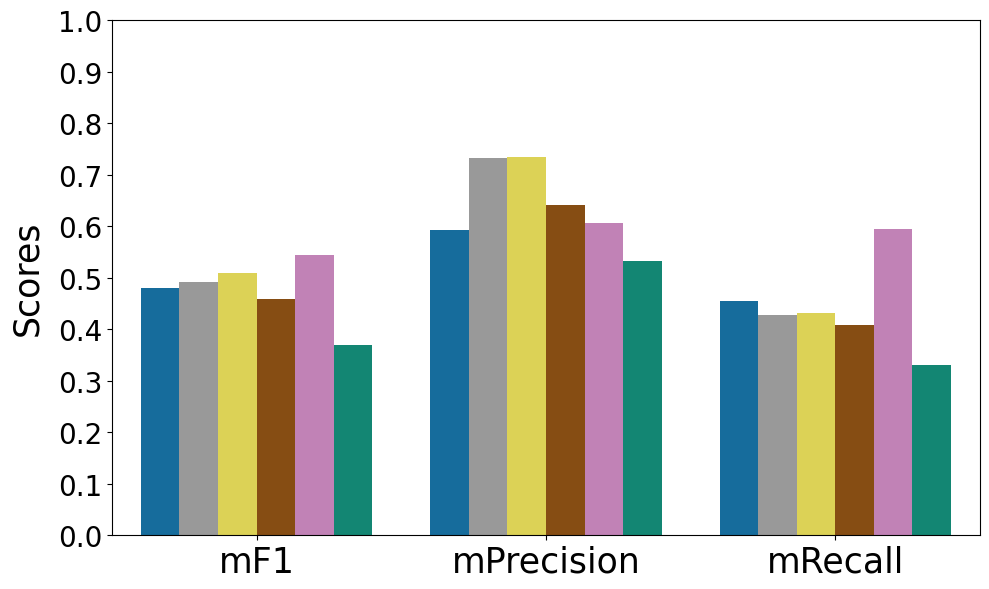

In [8]:
# plot the results of the three pipelines
import matplotlib.pyplot as plt
import numpy as np

labels = ['macro_f1_score', 'macro_precision_score', 'macro_recall_score']
pipeline_285_results = [results_pipeline_285[0]['macro_f1_score'], results_pipeline_285[0]['macro_precision_score'], results_pipeline_285[0]['macro_recall_score']]
pipeline_morgan_fp_results = [results_pipeline_morgan_fp[0]['macro_f1_score'], results_pipeline_morgan_fp[0]['macro_precision_score'], results_pipeline_morgan_fp[0]['macro_recall_score']]
pipeline_np_classifier_results = [results_np_classifier_fp[0]['macro_f1_score'], results_np_classifier_fp[0]['macro_precision_score'], results_np_classifier_fp[0]['macro_recall_score']]
pipeline_neural_npfp_results = [results_neural_np_fp[0]['macro_f1_score'], results_neural_np_fp[0]['macro_precision_score'], results_neural_np_fp[0]['macro_recall_score']]
pipeline_mhfp_results = [results_mhfp[0]['macro_f1_score'], results_mhfp[0]['macro_precision_score'], results_mhfp[0]['macro_recall_score']]

pipeline_285_std = [results_pipeline_285[0]['precision_scores_std'], results_pipeline_285[0]['precision_scores_std'], results_pipeline_285[0]['recall_scores_std']]
pipeline_morgan_fp_std = [results_pipeline_morgan_fp[0]['f1_scores_std'], results_pipeline_morgan_fp[0]['precision_scores_std'], results_pipeline_morgan_fp[0]['recall_scores_std']]
pipeline_np_classifier_std = [results_np_classifier_fp[0]['f1_scores_std'], results_np_classifier_fp[0]['precision_scores_std'], results_np_classifier_fp[0]['recall_scores_std']]
pipeline_mgcnn_results_std = [results_mgcnn["f1_score"].std(), results_mgcnn["precision"].std(), results_mgcnn["recall"].std()]
pipeline_neural_npfp_std = [results_neural_np_fp[0]['f1_scores_std'], results_neural_np_fp[0]['precision_scores_std'], results_neural_np_fp[0]['recall_scores_std']]
pipeline_mhfp_std = [results_mhfp[0]['f1_scores_std'], results_mhfp[0]['precision_scores_std'], results_mhfp[0]['recall_scores_std']]

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['savefig.transparent'] = True
# Sample data setup (replace with your actual data)
# Assuming you have your pipeline results as separate lists like before
# Here's how you might structure them into a DataFrame:

data = {
    "Label": labels * 6,  # Repeat 'labels' for each pipeline
    "Scores": np.concatenate([
        pipeline_285_results,
        pipeline_np_classifier_results,
        pipeline_morgan_fp_results,
        pipeline_mhfp_results,
        pipeline_mgcnn_results,
        pipeline_neural_npfp_results,
    ]),
    "STD": np.concatenate([
        pipeline_285_std,
        pipeline_np_classifier_std,
        pipeline_morgan_fp_std,
        pipeline_mhfp_std,
        pipeline_mgcnn_results_std,
        pipeline_neural_npfp_std
        
    ]),
    "Pipeline": (
        ["Layered FP + Low Variance FS + Ridge Classifier"] * len(labels) +
        ["NP classifier FP"] * len(labels) +
        ["Morgan FP + Ridge Classifier"] * len(labels) +
        ["MHFP"] * len(labels) +
         ["MGCNN (Eguchi et al. 2019)"] * len(labels) +
        ["Neural NPFP"] * len(labels)
        
    )
}

df = pd.DataFrame(data)
#df.sort_values(by="Scores", ascending=False, inplace=True)  # Sort by scores for better visualization

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
barplot = sns.barplot(data=df, x="Label", y="Scores", hue="Pipeline", dodge=True, palette=color_map)

legend = plt.legend(title='', bbox_to_anchor=(1.05, 1.15), loc='upper left', prop={'size': 25}, ncol=2)
fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig("legend.png", dpi="figure", bbox_inches=bbox)
legend.remove()

# for i, p in enumerate(barplot.patches):
#     # Calculate annotation text position
#     if p.get_height() != 0:
        # x = p.get_x() + p.get_width() / 2
        # # Get the corresponding standard deviation from the DataFrame
        # std = df.loc[i % len(df), 'STD']  # Adjust index for std
        # # Add error bar for this bar using plt.errorbar
        # plt.errorbar(x, p.get_height(), yerr=std, fmt='none', capsize=5, color='black')

        # barplot.annotate(format(p.get_height(), '.3f'),  # Text to display
        #                 (p.get_x() + p.get_width() / 2., p.get_height() + 0.05),  # Position
        #                 ha='center', va='center',  # Center alignment
        #                 xytext=(0, 9),  # Distance from the top of the bar
        #                 textcoords='offset points',
        #                 rotation=90)  # Text rotation (90 degrees)

plt.title('', pad=20, size=25)  # Adjust title position
plt.ylabel('Scores', labelpad=10, size=25)  # Adjust y-axis label position
plt.xlabel('', labelpad=10, size=25)
# define other names for the ticks
plt.xticks([0, 1, 2], ['mF1', 'mPrecision', 'mRecall'], size=25)

#plt.legend(title='Pipeline', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], size=20)

plt.tight_layout()  # Adjust layout
plt.savefig("overlapping_dataset_results.png", dpi=400)

In [42]:
from deepmol.loaders import CSVLoader
import numpy as np


def fit_and_evaluate(pipeline, pipeline_name):
    train = CSVLoader("training_set_overlapping.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()
    test = CSVLoader("overlapping_test_set.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

    pipeline.fit(train)
    from sklearn.metrics import f1_score, precision_score, recall_score
    from deepmol.metrics import Metric
    
    columns_to_remove = []
    for i in range(test.y.shape[1]):
        if np.sum(test.y[:, i]) == 0:
            columns_to_remove.append(i)
    

    predictions = pipeline.predict(test)
    f1_scores = []
    recall_scores = []
    precision_scores = []
    test = pipeline.transform(test)

    y_true = test.y
    y_true = np.delete(y_true, columns_to_remove, axis=1)
    y_pred = predictions
    y_pred = np.delete(y_pred, columns_to_remove, axis=1)
    tasks = []
    labels_to_consider = np.delete(train.label_names, columns_to_remove)
    for i in range(y_pred.shape[1]):
        f1_score_task = f1_score(y_true[:, i], y_pred[:, i])
        recall_score_task = recall_score(y_true[:, i], y_pred[:, i])
        precision_score_task = precision_score(y_true[:, i], y_pred[:, i])
        f1_scores.append(f1_score_task)
        recall_scores.append(recall_score_task)
        precision_scores.append(precision_score_task)
        tasks.append(labels_to_consider[i])
    
    results_test = pd.DataFrame({'task': tasks, 'f1_score': f1_scores, 'precision': precision_scores, 'recall': recall_scores, 'pipeline': [pipeline_name]*len(f1_scores)})

    return results_test

In [43]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"


def generate_plain_latex_table(df):
    # Start LaTeX table
    latex_table = "\\begin{table}[htbp]\n\\centering\n\\begin{tabular}{|" + "c|" * len(df.columns) + "}\n\\hline\n"
    
    # Add column headers
    headers = ' & '.join(df.columns) + " \\\\\n\\hline\n"
    latex_table += headers

    # Add rows with values from the DataFrame
    for index, row in df.iterrows():
        row_data = ' & '.join(map(str, row)) + " \\\\\n\\hline\n"
        latex_table += row_data
    
    # End LaTeX table
    latex_table += "\\end{tabular}\n\\caption{Significant Differences Table}\n\\end{table}"

    return latex_table

In [ ]:
pipeline_names = ["Layered FP + Ridge Classifier", "NPClassifierFP + Ridge Classifier", "MHFP + Ridge Classifier", "Morgan FP + Ridge Classifier", "Neural NPFP + MLPs (Classifier Chain)"]

import pandas as pd
results = pd.DataFrame()
for pipeline, name in zip([pipeline_285, pipeline_mhfp, pipeline_np_classifier, pipeline_morgan_fp, pipeline_neural_npfp], pipeline_names):
    print(name)
    results_ = fit_and_evaluate(pipeline, name)
    results = pd.concat([results, results_], axis=0)

In [45]:
import pandas as pd

results_mgcnn = pd.read_csv("results_overlapping.csv")
results_mgcnn.fillna(0, inplace=True)

f1_scores = []
precision_scores = []
recall_scores = []
tasks = []

for i in range(results_mgcnn.shape[0]):
    f1_scores.append(results_mgcnn["f1_score"][i])
    precision_scores.append(results_mgcnn["precision"][i])
    recall_scores.append(results_mgcnn["recall"][i])
    tasks.append(i)

results_mgcnn = pd.DataFrame({'task': tasks, 'f1_score': f1_scores, 'precision': precision_scores, 'recall': recall_scores, 'pipeline': ["MGCNN (Eguchi et al. 2019)"]*len(f1_scores)})
results = pd.concat([results, results_mgcnn], axis=0)

In [52]:
import itertools
import pandas as pd
from scipy import stats

# Assuming 'results' is your DataFrame containing the dataset
pipeline_names = results['pipeline'].unique()
significant_differences_f1 = []

for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    f1_scores1 = results[(results['pipeline'] == pipeline1)]['f1_score']
    f1_scores2 = results[(results['pipeline'] == pipeline2)]['f1_score']
    
    # Ensure both series have the same length for paired test
    if len(f1_scores1) == len(f1_scores2):
        stat, p_value = stats.wilcoxon(f1_scores1, f1_scores2)
        if p_value < 0.05:
            significant_differences_f1.append((pipeline1, pipeline2, p_value))

# Print out the pairs of pipelines that have significantly different F1 scores
for diff in significant_differences_f1:
    print(f"Significant difference between {diff[0]} and {diff[1]} with p-value {diff[2]}")

# generate a table with significant differences
significant_differences = significant_differences_f1
# transform p-values to asterisks
significant_differences = [(pipeline1, pipeline2, convert_pvalue_to_asterisks(pvalue)) for pipeline1, pipeline2, pvalue in significant_differences]

significant_differences_df = pd.DataFrame(significant_differences, columns=["Pipeline 1", "Pipeline 2", "Differences (F1 score)"])

latex_code = generate_plain_latex_table(significant_differences_df)
print(latex_code)

Significant difference between Neural NPFP + MLPs (Classifier Chain) and MGCNN (Eguchi et al. 2019) with p-value 0.002610776740525937
\begin{table}[htbp]
\centering
\begin{tabular}{|c|c|c|}
\hline
Pipeline 1 & Pipeline 2 & Differences (F1 score) \\
\hline
Neural NPFP + MLPs (Classifier Chain) & MGCNN (Eguchi et al. 2019) & ** \\
\hline
\end{tabular}
\caption{Significant Differences Table}
\end{table}


/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [54]:
import itertools
import pandas as pd
from scipy import stats

# Assuming 'results' is your DataFrame containing the dataset
pipeline_names = results['pipeline'].unique()
significant_differences_recall = []

for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    recall_scores1 = results[(results['pipeline'] == pipeline1)]['recall']
    recall_scores2 = results[(results['pipeline'] == pipeline2)]['recall']
    
    # Ensure both series have the same length for paired test
    if len(f1_scores1) == len(f1_scores2):
        stat, p_value = stats.wilcoxon(recall_scores1, recall_scores2)
        if p_value < 0.05:
            significant_differences_recall.append((pipeline1, pipeline2, p_value))

# Print out the pairs of pipelines that have significantly different F1 scores
for diff in significant_differences_recall:
    print(f"Significant difference between {diff[0]} and {diff[1]} with p-value {diff[2]}")


Significant difference between NPClassifierFP + Ridge Classifier and MGCNN (Eguchi et al. 2019) with p-value 0.007132413699395206
Significant difference between MHFP + Ridge Classifier and MGCNN (Eguchi et al. 2019) with p-value 0.04084746866268344
Significant difference between Neural NPFP + MLPs (Classifier Chain) and MGCNN (Eguchi et al. 2019) with p-value 0.0012182067404331491


In [55]:
# generate a table with significant differences
significant_differences = significant_differences_recall
# transform p-values to asterisks
significant_differences = [(pipeline1, pipeline2, convert_pvalue_to_asterisks(pvalue)) for pipeline1, pipeline2, pvalue in significant_differences]

significant_differences_df = pd.DataFrame(significant_differences, columns=["Pipeline 1", "Pipeline 2", "Differences (Recall score)"])

latex_code = generate_plain_latex_table(significant_differences_df)
print(latex_code)

\begin{table}[htbp]
\centering
\begin{tabular}{|c|c|c|}
\hline
Pipeline 1 & Pipeline 2 & Differences (Recall score) \\
\hline
NPClassifierFP + Ridge Classifier & MGCNN (Eguchi et al. 2019) & ** \\
\hline
MHFP + Ridge Classifier & MGCNN (Eguchi et al. 2019) & * \\
\hline
Neural NPFP + MLPs (Classifier Chain) & MGCNN (Eguchi et al. 2019) & ** \\
\hline
\end{tabular}
\caption{Significant Differences Table}
\end{table}


In [56]:
import itertools
import pandas as pd
from scipy import stats

# Assuming 'results' is your DataFrame containing the dataset
pipeline_names = results['pipeline'].unique()
significant_differences_precision = []

for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    precision_scores1 = results[(results['pipeline'] == pipeline1)]['precision']
    precision_scores2 = results[(results['pipeline'] == pipeline2)]['precision']
    
    # Ensure both series have the same length for paired test
    if len(precision_scores1) == len(precision_scores2):
        stat, p_value = stats.wilcoxon(precision_scores1, precision_scores2)
        if p_value < 0.05:
            significant_differences_precision.append((pipeline1, pipeline2, p_value))

# Print out the pairs of pipelines that have significantly different F1 scores
for diff in significant_differences_precision:
    print(f"Significant difference between {diff[0]} and {diff[1]} with p-value {diff[2]}")


Significant difference between MHFP + Ridge Classifier and Neural NPFP + MLPs (Classifier Chain) with p-value 0.04066072250322513
Significant difference between Morgan FP + Ridge Classifier and Neural NPFP + MLPs (Classifier Chain) with p-value 0.04656776138686537


/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [58]:
# generate a table with significant differences
significant_differences = significant_differences_precision
# transform p-values to asterisks
significant_differences = [(pipeline1, pipeline2, convert_pvalue_to_asterisks(pvalue)) for pipeline1, pipeline2, pvalue in significant_differences]

significant_differences_df = pd.DataFrame(significant_differences, columns=["Pipeline 1", "Pipeline 2", "Differences (Precision score)"])

latex_code = generate_plain_latex_table(significant_differences_df)
print(latex_code)

\begin{table}[htbp]
\centering
\begin{tabular}{|c|c|c|}
\hline
Pipeline 1 & Pipeline 2 & Differences (Precision score) \\
\hline
MHFP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & * \\
\hline
Morgan FP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & * \\
\hline
\end{tabular}
\caption{Significant Differences Table}
\end{table}


In [65]:
def get_scores_by_task(pipeline):
    train = CSVLoader("training_set_overlapping.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()
    test = CSVLoader("overlapping_test_set.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()
    

    pipeline.fit(train)
    from sklearn.metrics import f1_score, precision_score, recall_score

    columns_to_remove = []
    for i in range(test.y.shape[1]):
        if np.sum(test.y[:, i]) == 0:
            columns_to_remove.append(i)

    predictions = pipeline.predict(test)
    test = pipeline.transform(test)

    tasks_f1_score = []
    tasks_precision = []
    tasks_recall = []

    y_true = test.y
    y_true = np.delete(y_true, columns_to_remove, axis=1)
    y_pred = predictions
    y_pred = np.delete(y_pred, columns_to_remove, axis=1)
    tasks = []
    labels_to_consider = np.delete(train.label_names, columns_to_remove)

    for i in range(y_pred.shape[1]):
        f1_score_task = f1_score(y_true[:, i], y_pred[:, i])
        recall_score_task = recall_score(y_true[:, i], y_pred[:, i])
        precision_score_task = precision_score(y_true[:, i], y_pred[:, i])
        tasks_f1_score.append(f1_score_task)
        tasks_precision.append(recall_score_task)
        tasks_recall.append(precision_score_task)
        tasks.append(labels_to_consider[i])

    return tasks_f1_score, tasks_precision, tasks_recall

In [ ]:
f1_scores_285, precision_285, recall_285 = get_scores_by_task(pipeline_285)
f1_scores_morgan_fp, precision_morgan_fp, recall_morgan_fp = get_scores_by_task(pipeline_morgan_fp)
f1_scores_mhfp, precision_morgan_mhfp, recall_morgan_mhfp = get_scores_by_task(pipeline_mhfp)
f1_scores_np_classifier, precision_np_classifier, recall_np_classifier = get_scores_by_task(pipeline_np_classifier)
f1_scores_neural_npfp, precision_neural_npfp, recall_neural_npfp = get_scores_by_task(pipeline_neural_npfp)

In [71]:
from deepmol.loaders import CSVLoader

test = CSVLoader("overlapping_test_set.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

labels = {
    'C00341': 'Geranyl diphosphate',
    'C01789': 'Campesterol',
    'C00078': 'Tryptophan',
    'C00049': 'L-Aspartate',
    'C00183': 'L-Valine',
    'C03506': 'Indoleglycerol phosphate',
    'C00187': 'Cholesterol',
    'C00079': 'L-Phenylalanine',
    'C00047': 'L-Lysine',
    'C01852': 'Secologanin',
    'C00407': 'L-Isoleucine',
    'C00129': 'Isopentenyl diphosphate',
    'C00235': 'Dimethylallyl diphosphate',
    'C00062': 'L-Arginine',
    'C00353': 'Geranylgeranyl diphosphate',
    'C00148': 'L-Proline',
    'C00073': 'L-Methionine',
    'C00108': 'Anthranilate',
    'C00123': 'L-Leucine',
    'C00135': 'L-Histidine',
    'C00448': 'Farnesyl diphosphate',
    'C00082': 'L-Tyrosine',
    'C00041': 'L-Alanine',
    'C00540': 'Cinnamoyl-CoA',
    'C01477': 'Apigenin',
    'C05903': 'Kaempferol',
    'C05904': 'Pelargonin',
    'C05905': 'Cyanidin',
    'C05908': 'Delphinidin',
    'C00389': 'Quercetin',
    'C01514': 'Luteolin',
    'C09762': "Liquiritigenin",
    'C00509': 'Naringenin',
    'C00223': 'p-Coumaroyl-CoA'
}


columns_to_remove = []
for i in range(test.y.shape[1]):
    if np.sum(test.y[:, i]) == 0:
        columns_to_remove.append(i)

labels_to_consider = np.delete(test.label_names, columns_to_remove)
labels_names = [labels[name] for name in labels_to_consider]
len(labels_names)

2024-10-04 15:08:27,642 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


20

In [73]:
results_mgcnn = pd.read_csv("results_overlapping.csv")
results_mgcnn.fillna(0, inplace=True)

f1_scores_mgcnn = results_mgcnn.loc[:, "f1_score"].tolist()
recall_mgcnn = results_mgcnn.loc[:, "recall"].tolist()
precision_mgcnn = results_mgcnn.loc[:, "precision"].tolist()

In [75]:
f1_scores = [f1_scores_285, f1_scores_np_classifier, f1_scores_mhfp, f1_scores_morgan_fp, f1_scores_mgcnn, f1_scores_neural_npfp]
pipeline_names = ["Layered FP + Ridge Classifier", "NPClassifierFP + Ridge Classifier", "MHFP + Ridge Classifier", "Morgan FP + Ridge Classifier", "MGCNN (Eguchi et al. 2019)", "Neural NPFP + MLPs (Classifier Chain)"]

df = pd.DataFrame(f1_scores, columns=labels_names, index=pipeline_names)

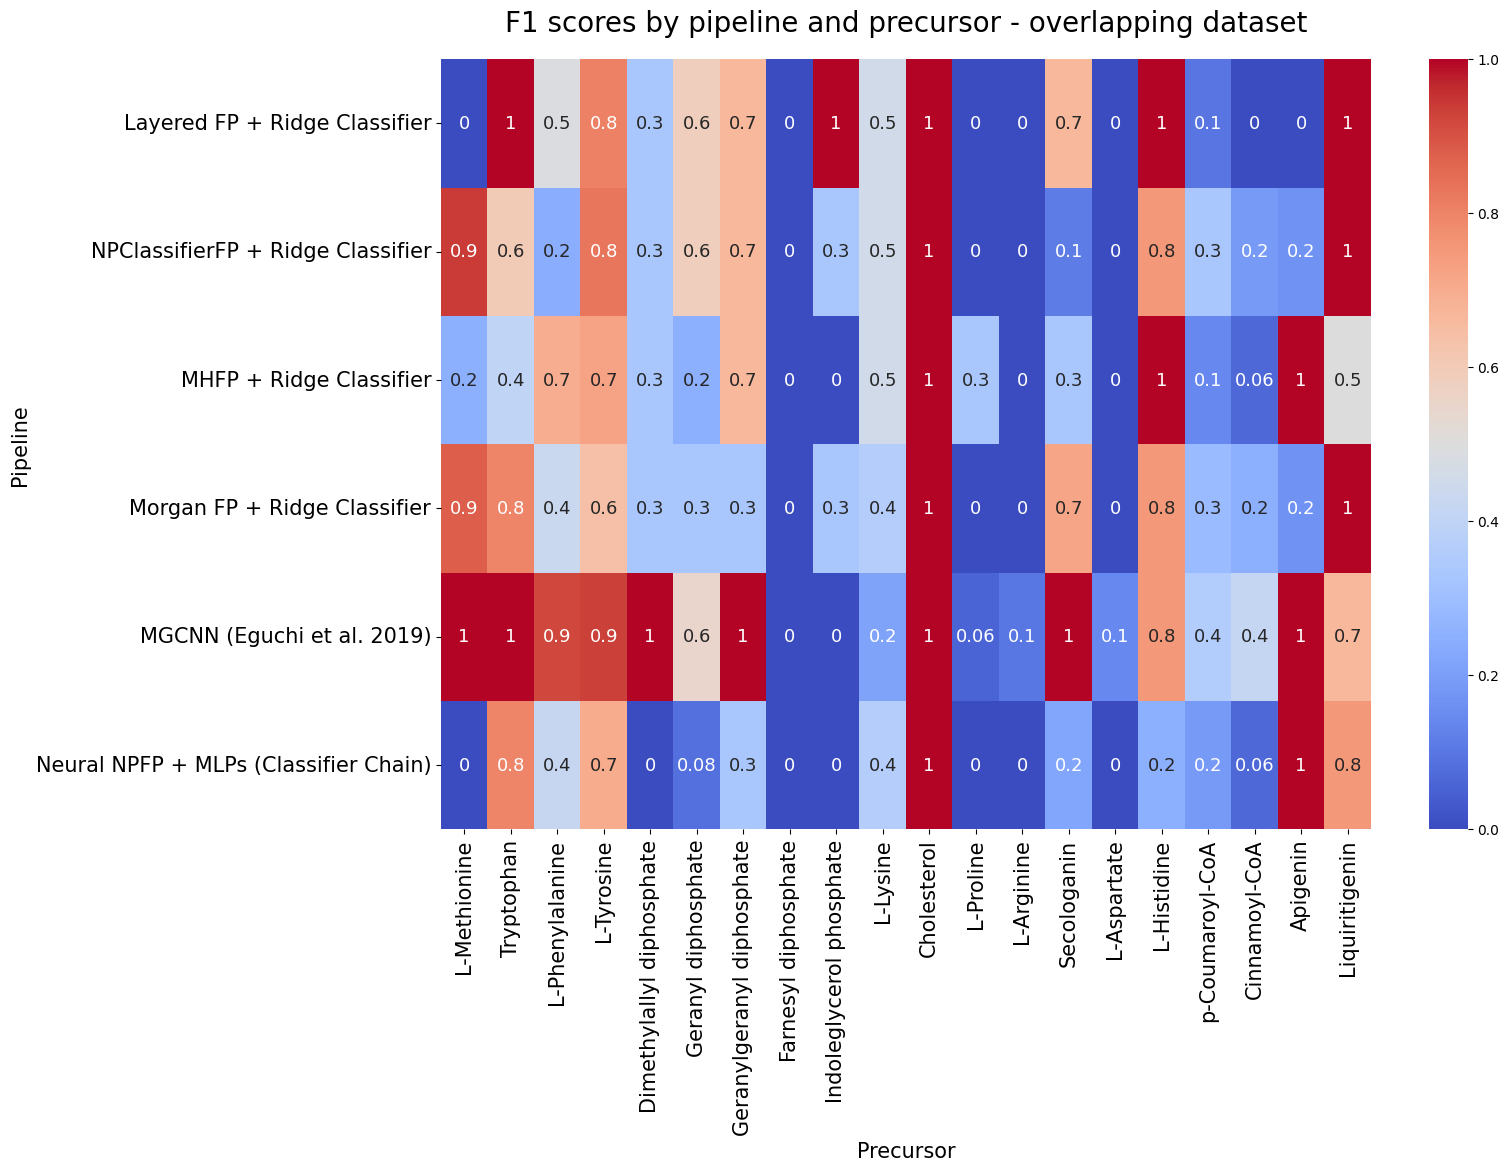

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='.1g', annot_kws={"size": 13})
plt.title('F1 scores by pipeline and precursor - overlapping dataset', pad=20, size=20)
plt.xlabel('Precursor', size=15)
plt.ylabel('Pipeline', size=15)
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig("f1_scores_by_pipeline_and_precursor.png", transparent=True)
plt.show()

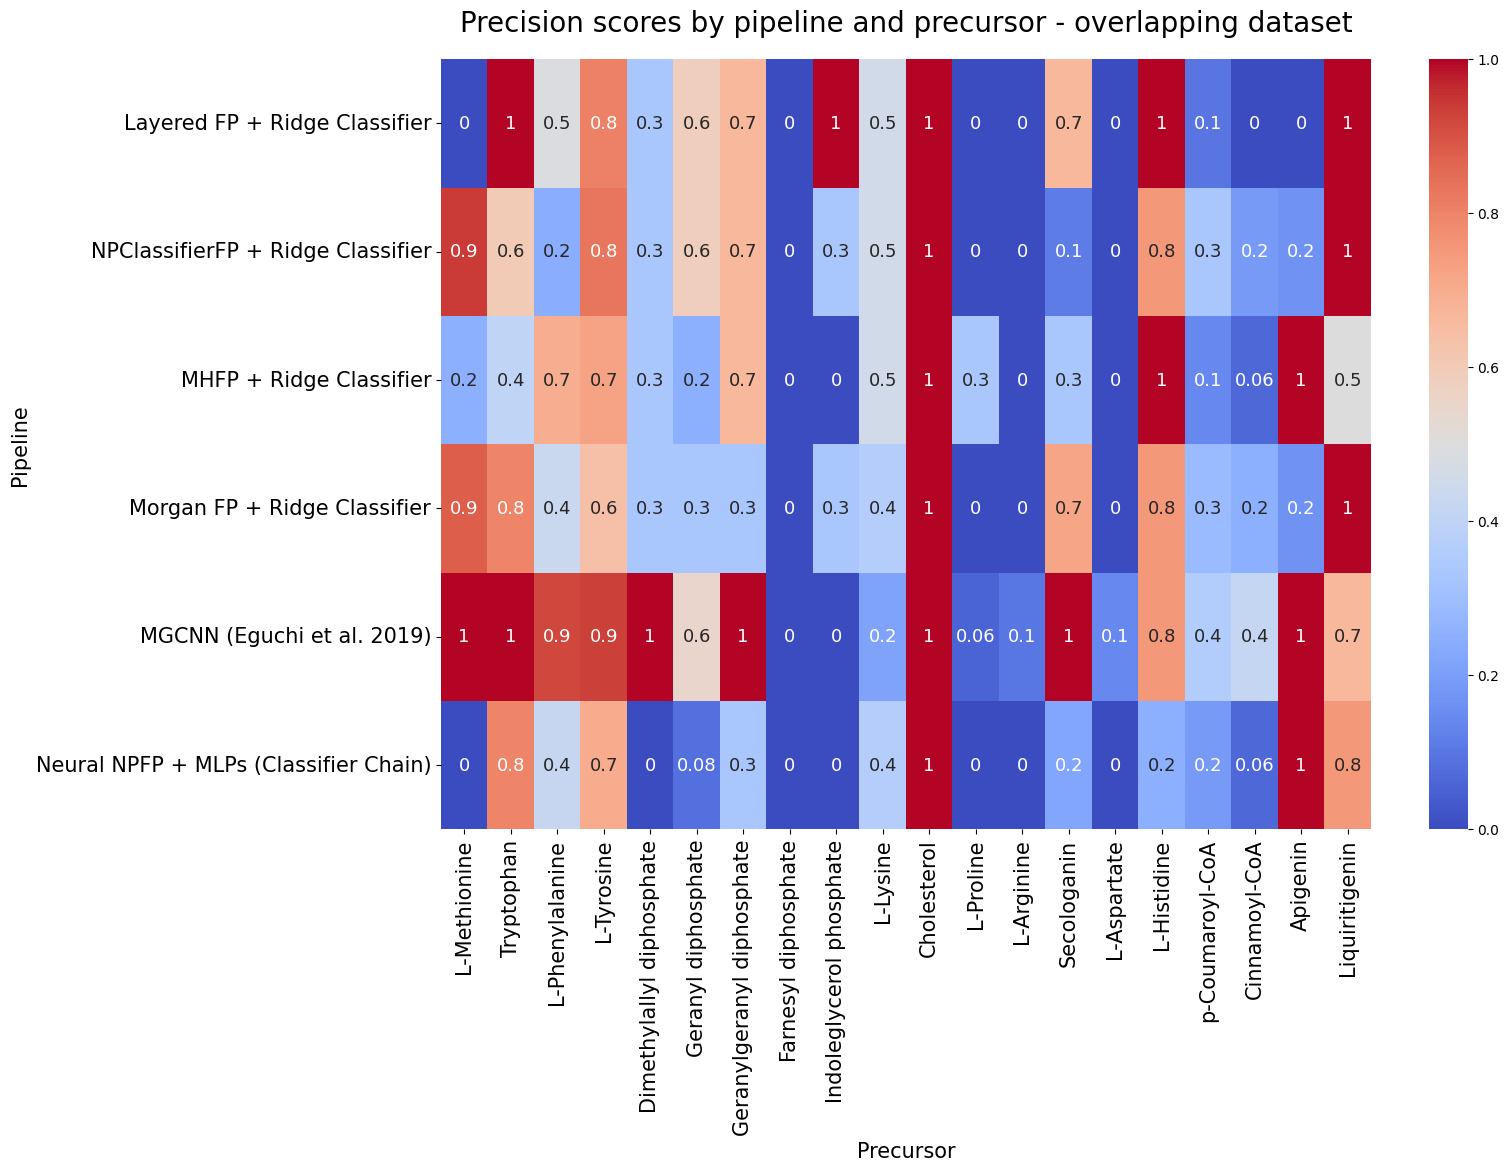

In [79]:
precision_scores = [precision_285, precision_np_classifier, precision_morgan_mhfp, precision_morgan_fp, precision_mgcnn, precision_neural_npfp]
pipeline_names = ["Layered FP + Ridge Classifier", "NPClassifierFP + Ridge Classifier", "MHFP + Ridge Classifier", "Morgan FP + Ridge Classifier", "MGCNN (Eguchi et al. 2019)", "Neural NPFP + MLPs (Classifier Chain)"]

df = pd.DataFrame(precision_scores, columns=labels_names, index=pipeline_names)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='.1g', annot_kws={"size": 13})
plt.title('Precision scores by pipeline and precursor - overlapping dataset', pad=20, size=20)
plt.xlabel('Precursor', size=15)
plt.ylabel('Pipeline', size=15)
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig("precision_scores_by_pipeline_and_precursor.png", transparent=True)
plt.show()


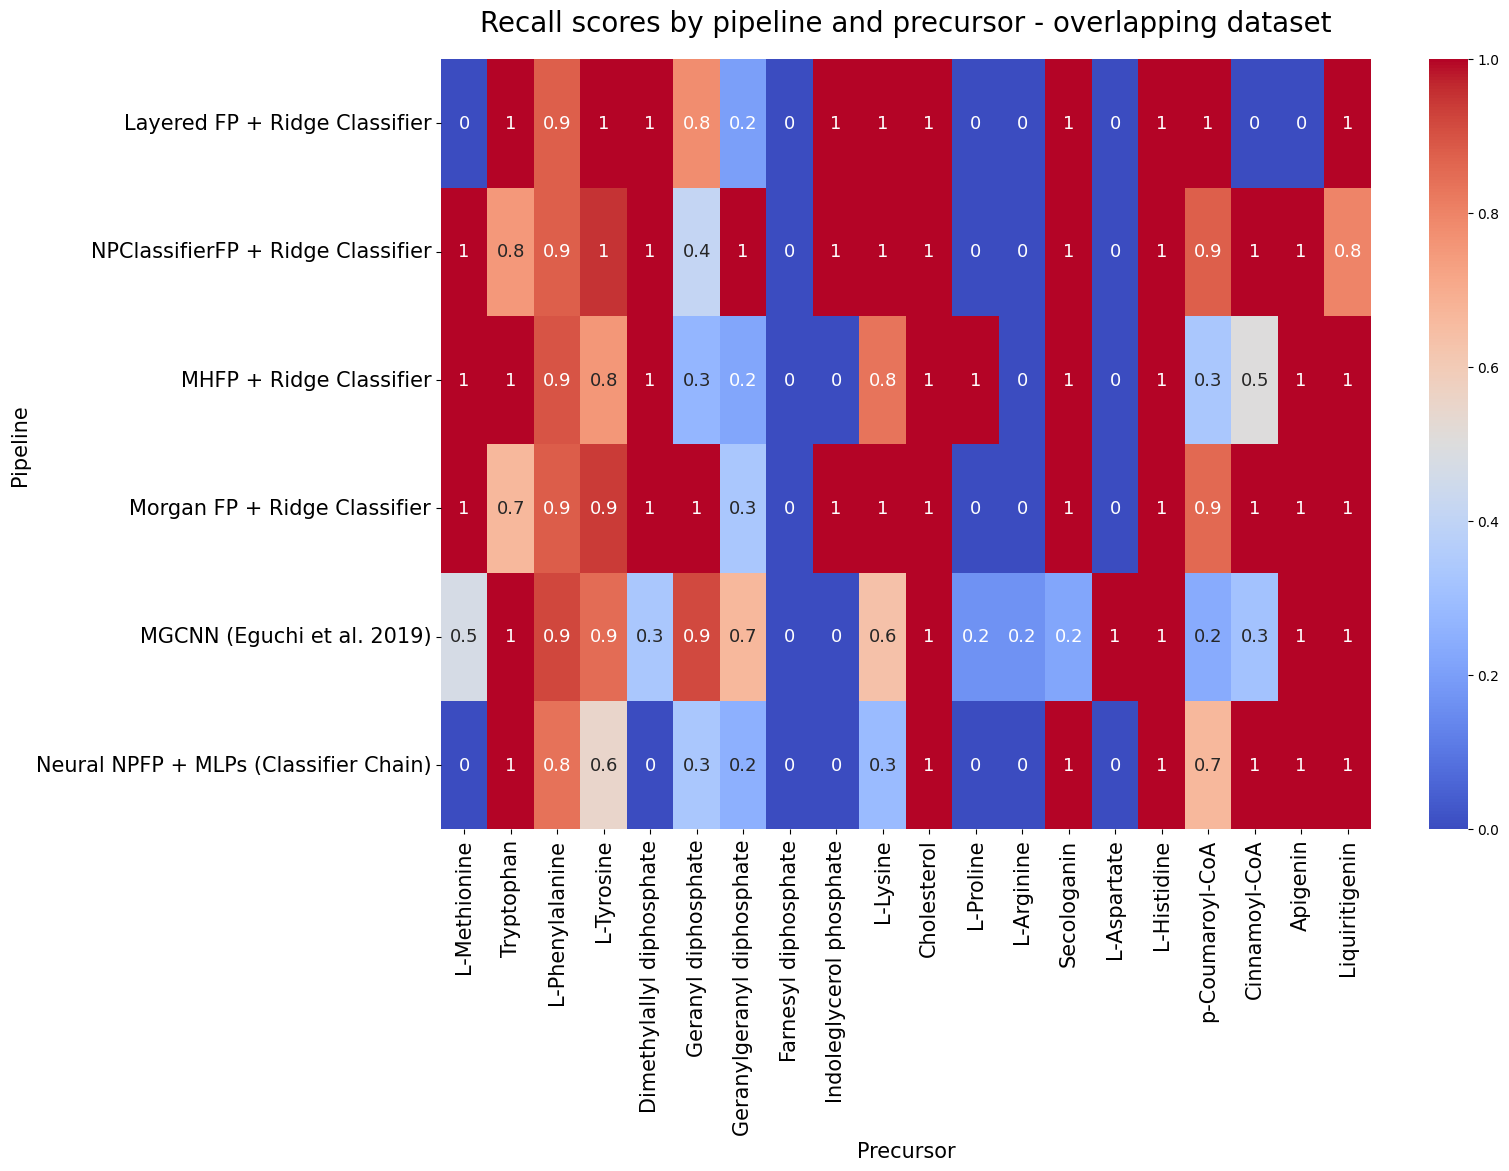

In [81]:
# Replace precision with recall
recall_scores = [recall_285, recall_np_classifier, recall_morgan_mhfp, recall_morgan_fp, recall_mgcnn, recall_neural_npfp]
pipeline_names = ["Layered FP + Ridge Classifier", "NPClassifierFP + Ridge Classifier", "MHFP + Ridge Classifier", "Morgan FP + Ridge Classifier", "MGCNN (Eguchi et al. 2019)", "Neural NPFP + MLPs (Classifier Chain)"]

# Create a DataFrame using recall scores
df = pd.DataFrame(recall_scores, columns=labels_names, index=pipeline_names)

# Plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='.1g', annot_kws={"size": 13})
plt.title('Recall scores by pipeline and precursor - overlapping dataset', pad=20, size=20)
plt.xlabel('Precursor', size=15)
plt.ylabel('Pipeline', size=15)
plt.yticks(size=15)
plt.xticks(size=15)

# Update the filename for recall
plt.savefig("recall_scores_by_pipeline_and_precursor.png", transparent=True)
plt.show()


# Clustering dataset

In [16]:
from deepmol.loaders import CSVLoader
import numpy as np

train = CSVLoader("training_set_clustered.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

for column in range(train.y.shape[1]):
    if len(np.unique(train.y[:, column])) == 1:
        print(train.label_names[column])

2024-10-01 18:42:15,180 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


In [17]:
from deepmol.loaders import CSVLoader
import numpy as np


def fit_and_evaluate(pipeline):
    train = CSVLoader("training_set_clustered.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()
    test = CSVLoader("clustered_test_set.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

    pipeline.fit(train)
    from sklearn.metrics import f1_score, precision_score, recall_score
    from deepmol.metrics import Metric
    
    columns_to_remove = []
    for i in range(test.y.shape[1]):
        if np.sum(test.y[:, i]) == 0:
            columns_to_remove.append(i)
    

    predictions = pipeline.predict(test)
    f1_scores = []
    recall_scores = []
    precision_scores = []
    test = pipeline.transform(test)

    y_true = test.y
    y_true = np.delete(y_true, columns_to_remove, axis=1)
    y_pred = predictions
    y_pred = np.delete(y_pred, columns_to_remove, axis=1)

    for i in range(y_pred.shape[1]):
        f1_score_task = f1_score(y_true[:, i], y_pred[:, i])
        recall_score_task = recall_score(y_true[:, i], y_pred[:, i])
        precision_score_task = precision_score(y_true[:, i], y_pred[:, i])
        f1_scores.append(f1_score_task)
        recall_scores.append(recall_score_task)
        precision_scores.append(precision_score_task)
    
    results_test = [{}]
    results_test[0]['f1_scores_std'] = np.array(f1_scores).std()
    results_test[0]['recall_scores_std'] = np.array(recall_scores).std()
    results_test[0]['precision_scores_std'] = np.array(precision_scores).std()
    results_test[0]['macro_f1_score'] = np.array(f1_scores).mean()
    results_test[0]['macro_recall_score'] = np.array(recall_scores).mean()
    results_test[0]['macro_precision_score'] = np.array(precision_scores).mean()

    return results_test

In [ ]:
from deepmol.pipeline import Pipeline

print("Morgan FP")
results_pipeline_morgan_fp = fit_and_evaluate(pipeline_morgan_fp)
print("Layered FP and Ridge Classifier (optimized)")
results_pipeline_285 = fit_and_evaluate(pipeline_285)

print("NP classifier")
results_np_classifier_fp = fit_and_evaluate(pipeline_np_classifier)
print("MHFP")
results_mhfp = fit_and_evaluate(pipeline_mhfp)
print("Neural NP FP")
results_neural_np_fp = fit_and_evaluate(pipeline_neural_npfp)


In [19]:
import os
os.makedirs("results", exist_ok=True)

import pickle

with open("results/results_pipeline_morgan_fp_clustering_dataset.pkl", "wb") as f:
    pickle.dump(results_pipeline_morgan_fp, f)

with open("results/results_pipeline_285_clustering_dataset.pkl", "wb") as f:
    pickle.dump(results_pipeline_285, f)

with open("results/results_np_classifier_fp_clustering_dataset.pkl", "wb") as f:
    pickle.dump(results_np_classifier_fp, f)

with open("results/results_mhfp_clustering_dataset.pkl", "wb") as f:
    pickle.dump(results_mhfp, f)

with open("results/results_neural_np_fp_clustering_dataset.pkl", "wb") as f:
    pickle.dump(results_neural_np_fp, f)



In [20]:
import pandas as pd

results_mgcnn = pd.read_csv("mgcnn_results_clustered.csv")
results_mgcnn.fillna(0, inplace=True)
mgcnn_results = [results_mgcnn["f1_score"].mean(), results_mgcnn["precision"].mean(), results_mgcnn["recall"].mean()]
mgcnn_results

[0.4962027497203994, 0.49823149336777156, 0.5944426643944623]

In [21]:
color_map = {
    'Layered FP + Low Variance FS + Ridge Classifier': (0.0, 0.45, 0.7),  # Strong blue
    'Morgan FP + Ridge Classifier': (0.95, 0.9, 0.25),  # Golden yellow
    'Morgan FP + MLP': (0.35, 0.7, 0.9),  # Light cyan
    'MGCNN (Eguchi et al. 2019)': (0.8, 0.47, 0.74),  # Light purple
    'Neural NPFP': (0.0, 0.6, 0.5),  # Strong teal (greenish-blue)
    'MHFP': (0.6, 0.3, 0.0),  # Dark brown-orange
    'NP classifier FP': (0.6, 0.6, 0.6),  # Neutral gray
}


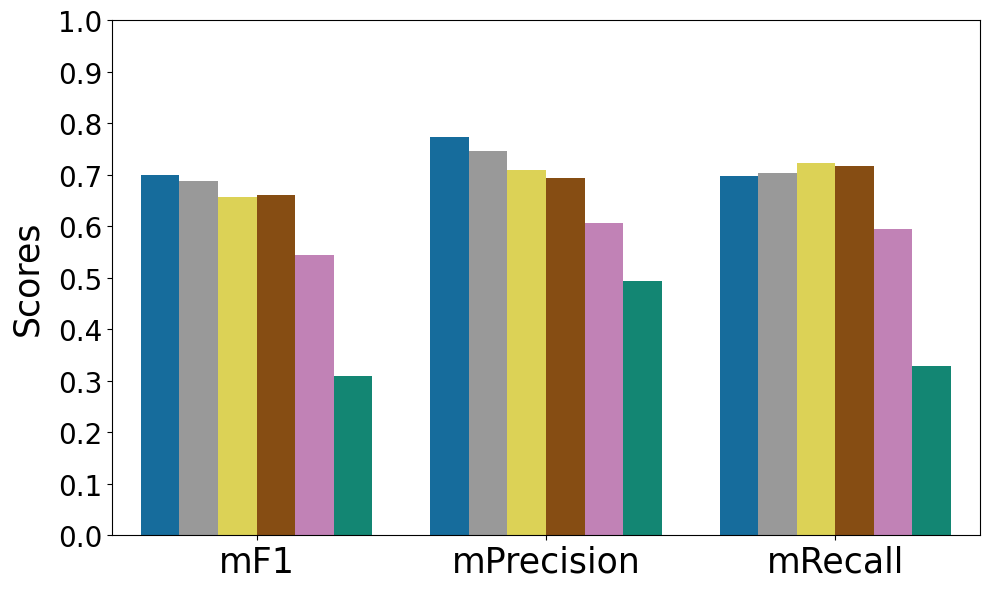

In [22]:
# plot the results of the three pipelines
import matplotlib.pyplot as plt
import numpy as np

labels = ['macro_f1_score', 'macro_precision_score', 'macro_recall_score']
pipeline_285_results = [results_pipeline_285[0]['macro_f1_score'], results_pipeline_285[0]['macro_precision_score'], results_pipeline_285[0]['macro_recall_score']]
pipeline_morgan_fp_results = [results_pipeline_morgan_fp[0]['macro_f1_score'], results_pipeline_morgan_fp[0]['macro_precision_score'], results_pipeline_morgan_fp[0]['macro_recall_score']]
pipeline_np_classifier_results = [results_np_classifier_fp[0]['macro_f1_score'], results_np_classifier_fp[0]['macro_precision_score'], results_np_classifier_fp[0]['macro_recall_score']]
pipeline_neural_npfp_results = [results_neural_np_fp[0]['macro_f1_score'], results_neural_np_fp[0]['macro_precision_score'], results_neural_np_fp[0]['macro_recall_score']]
pipeline_mhfp_results = [results_mhfp[0]['macro_f1_score'], results_mhfp[0]['macro_precision_score'], results_mhfp[0]['macro_recall_score']]

pipeline_285_std = [results_pipeline_285[0]['precision_scores_std'], results_pipeline_285[0]['precision_scores_std'], results_pipeline_285[0]['recall_scores_std']]
pipeline_morgan_fp_std = [results_pipeline_morgan_fp[0]['f1_scores_std'], results_pipeline_morgan_fp[0]['precision_scores_std'], results_pipeline_morgan_fp[0]['recall_scores_std']]
pipeline_np_classifier_std = [results_np_classifier_fp[0]['f1_scores_std'], results_np_classifier_fp[0]['precision_scores_std'], results_np_classifier_fp[0]['recall_scores_std']]
pipeline_mgcnn_results_std = [results_mgcnn["f1_score"].std(), results_mgcnn["precision"].std(), results_mgcnn["recall"].std()]
pipeline_neural_npfp_std = [results_neural_np_fp[0]['f1_scores_std'], results_neural_np_fp[0]['precision_scores_std'], results_neural_np_fp[0]['recall_scores_std']]
pipeline_mhfp_std = [results_mhfp[0]['f1_scores_std'], results_mhfp[0]['precision_scores_std'], results_mhfp[0]['recall_scores_std']]

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['savefig.transparent'] = True
# Sample data setup (replace with your actual data)
# Assuming you have your pipeline results as separate lists like before
# Here's how you might structure them into a DataFrame:

data = {
    "Label": labels * 6,  # Repeat 'labels' for each pipeline
    "Scores": np.concatenate([
        pipeline_285_results,
        pipeline_np_classifier_results,
        pipeline_morgan_fp_results,
        pipeline_mhfp_results,
        pipeline_mgcnn_results,
        pipeline_neural_npfp_results,
    ]),
    "STD": np.concatenate([
        pipeline_285_std,
        pipeline_np_classifier_std,
        pipeline_morgan_fp_std,
        pipeline_mhfp_std,
        pipeline_mgcnn_results_std,
        pipeline_neural_npfp_std
        
    ]),
    "Pipeline": (
        ["Layered FP + Low Variance FS + Ridge Classifier"] * len(labels) +
        ["NP classifier FP"] * len(labels) +
        ["Morgan FP + Ridge Classifier"] * len(labels) +
        ["MHFP"] * len(labels) +
         ["MGCNN (Eguchi et al. 2019)"] * len(labels) +
        ["Neural NPFP"] * len(labels)
        
    )
}

df = pd.DataFrame(data)
#df.sort_values(by="Scores", ascending=False, inplace=True)  # Sort by scores for better visualization

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
barplot = sns.barplot(data=df, x="Label", y="Scores", hue="Pipeline", dodge=True, palette=color_map)
legend = plt.legend(title='', bbox_to_anchor=(1.05, 1.15), loc='upper left', prop={'size': 25}, ncol=2)
fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
legend.remove()
# for i, p in enumerate(barplot.patches):
#     # Calculate annotation text position
#     if p.get_height() != 0:
        # x = p.get_x() + p.get_width() / 2
        # # Get the corresponding standard deviation from the DataFrame
        # std = df.loc[i % len(df), 'STD']  # Adjust index for std
        # # Add error bar for this bar using plt.errorbar
        # plt.errorbar(x, p.get_height(), yerr=std, fmt='none', capsize=5, color='black')

        # barplot.annotate(format(p.get_height(), '.3f'),  # Text to display
        #                 (p.get_x() + p.get_width() / 2., p.get_height() + 0.05),  # Position
        #                 ha='center', va='center',  # Center alignment
        #                 xytext=(0, 9),  # Distance from the top of the bar
        #                 textcoords='offset points',
                        # rotation=90)  # Text rotation (90 degrees)

plt.title('', pad=20, size=25)  # Adjust title position
plt.ylabel('Scores', labelpad=10, size=25)  # Adjust y-axis label position
plt.xlabel('', labelpad=10, size=25)
# define other names for the ticks
plt.xticks([0, 1, 2], ['mF1', 'mPrecision', 'mRecall'], size=25)

#plt.legend(title='Pipeline', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], size=20)

plt.tight_layout()  # Adjust layout
plt.savefig("clustered_dataset.png", dpi=400)

In [4]:
from deepmol.loaders import CSVLoader
import numpy as np

labels = {
    'C00341': 'Geranyl diphosphate',
    'C01789': 'Campesterol',
    'C00078': 'Tryptophan',
    'C00049': 'L-Aspartate',
    'C00183': 'L-Valine',
    'C03506': 'Indoleglycerol phosphate',
    'C00187': 'Cholesterol',
    'C00079': 'L-Phenylalanine',
    'C00047': 'L-Lysine',
    'C01852': 'Secologanin',
    'C00407': 'L-Isoleucine',
    'C00129': 'Isopentenyl diphosphate',
    'C00235': 'Dimethylallyl diphosphate',
    'C00062': 'L-Arginine',
    'C00353': 'Geranylgeranyl diphosphate',
    'C00148': 'L-Proline',
    'C00073': 'L-Methionine',
    'C00108': 'Anthranilate',
    'C00123': 'L-Leucine',
    'C00135': 'L-Histidine',
    'C00448': 'Farnesyl diphosphate',
    'C00082': 'L-Tyrosine',
    'C00041': 'L-Alanine',
    'C00540': 'Cinnamoyl-CoA',
    'C01477': 'Apigenin',
    'C05903': 'Kaempferol',
    'C05904': 'Pelargonin',
    'C05905': 'Cyanidin',
    'C05908': 'Delphinidin',
    'C00389': 'Quercetin',
    'C01514': 'Luteolin',
    'C09762': "Liquiritigenin",
    'C00509': 'Naringenin',
    'C00223': 'p-Coumaroyl-CoA'
}
global columns_that_stay
columns_that_stay = []

def fit_and_evaluate(pipeline, pipeline_name):
    train = CSVLoader("training_set_clustered.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()
    test = CSVLoader("clustered_test_set.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

    pipeline.fit(train)
    from sklearn.metrics import f1_score, precision_score, recall_score
    from deepmol.metrics import Metric
    
    columns_to_remove = []
    columns_that_stay = []
    for i in range(test.y.shape[1]):
        if np.sum(test.y[:, i]) == 0:
            columns_to_remove.append(i)
        else:
            columns_that_stay.append(labels[test.label_names[i]])
    
    predictions = pipeline.predict(test)
    f1_scores = []
    recall_scores = []
    precision_scores = []
    test = pipeline.transform(test)

    y_true = test.y
    y_true = np.delete(y_true, columns_to_remove, axis=1)
    y_pred = predictions
    y_pred = np.delete(y_pred, columns_to_remove, axis=1)
    tasks = []
    for i in range(y_pred.shape[1]):
        f1_score_task = f1_score(y_true[:, i], y_pred[:, i])
        recall_score_task = recall_score(y_true[:, i], y_pred[:, i])
        precision_score_task = precision_score(y_true[:, i], y_pred[:, i])
        f1_scores.append(f1_score_task)
        recall_scores.append(recall_score_task)
        precision_scores.append(precision_score_task)
        tasks.append(i)
    
    results_test = pd.DataFrame({'task': tasks, 'f1_score': f1_scores, 'precision': precision_scores, 'recall': recall_scores, 'pipeline': [pipeline_name]*len(f1_scores)})

    return results_test

In [ ]:
pipeline_names = ["Layered FP + Ridge Classifier", "NPClassifierFP + Ridge Classifier", "MHFP + Ridge Classifier", "Morgan FP + Ridge Classifier", "Neural NPFP + MLPs (Classifier Chain)"]

import pandas as pd
results = pd.DataFrame()
for pipeline, name in zip([pipeline_285, pipeline_mhfp, pipeline_np_classifier, pipeline_morgan_fp, pipeline_neural_npfp], pipeline_names):
    print(name)
    results_ = fit_and_evaluate(pipeline, name)
    results = pd.concat([results, results_], axis=0)

In [21]:
import pandas as pd

results_mgcnn = pd.read_csv("mgcnn_results_clustered.csv")
results_mgcnn.fillna(0, inplace=True)

f1_scores = []
precision_scores = []
recall_scores = []
tasks = []

for i in range(results_mgcnn.shape[0]):
    f1_scores.append(results_mgcnn["f1_score"][i])
    precision_scores.append(results_mgcnn["precision"][i])
    recall_scores.append(results_mgcnn["recall"][i])
    tasks.append(i)

results_mgcnn = pd.DataFrame({'task': tasks, 'f1_score': f1_scores, 'precision': precision_scores, 'recall': recall_scores, 'pipeline': ["MGCNN (Eguchi et al. 2019)"]*len(f1_scores)})
results = pd.concat([results, results_mgcnn], axis=0)

In [22]:
import itertools
import pandas as pd
from scipy import stats

# Assuming 'results' is your DataFrame containing the dataset
pipeline_names = results['pipeline'].unique()
significant_differences_f1 = []

for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    f1_scores1 = results[(results['pipeline'] == pipeline1)]['f1_score']
    f1_scores2 = results[(results['pipeline'] == pipeline2)]['f1_score']
    print(pipeline1, pipeline2)
    # put both series side by side and print them
    print(pd.concat([f1_scores1, f1_scores2], axis=1))
    

Layered FP + Ridge Classifier NPClassifierFP + Ridge Classifier
    f1_score  f1_score
0   0.971831  0.908425
1   0.849162  0.839080
2   0.000000  0.000000
3   0.437500  0.958333
4   1.000000  0.500000
5   0.710526  0.566667
6   0.823529  0.823529
7   0.000000  0.000000
8   0.444444  0.444444
9   0.842105  0.846154
10  1.000000  0.962963
11  0.967742  0.967742
12  0.969697  0.864865
13  0.774194  0.566038
Layered FP + Ridge Classifier MHFP + Ridge Classifier
    f1_score  f1_score
0   0.971831  0.890566
1   0.849162  0.899471
2   0.000000  0.000000
3   0.437500  1.000000
4   1.000000  1.000000
5   0.710526  0.400000
6   0.823529  0.823529
7   0.000000  0.000000
8   0.444444  0.444444
9   0.842105  0.782609
10  1.000000  0.962963
11  0.967742  0.967742
12  0.969697  0.888889
13  0.774194  0.566038
Layered FP + Ridge Classifier Morgan FP + Ridge Classifier
    f1_score  f1_score
0   0.971831  0.923636
1   0.849162  0.880435
2   0.000000  0.041667
3   0.437500  0.913043
4   1.000000  0.66

In [25]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [24]:
import itertools
import pandas as pd
from scipy import stats

# Assuming 'results' is your DataFrame containing the dataset
pipeline_names = results['pipeline'].unique()
significant_differences_f1 = []

for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    f1_scores1 = results[(results['pipeline'] == pipeline1)]['f1_score']
    f1_scores2 = results[(results['pipeline'] == pipeline2)]['f1_score']
    
    # Ensure both series have the same length for paired test
    if len(f1_scores1) == len(f1_scores2):
        stat, p_value = stats.wilcoxon(f1_scores1, f1_scores2)
        if p_value < 0.05:
            significant_differences_f1.append((pipeline1, pipeline2, p_value))

# Print out the pairs of pipelines that have significantly different F1 scores
for diff in significant_differences_f1:
    print(f"Significant difference between {diff[0]} and {diff[1]} with p-value {diff[2]}")




Significant difference between Layered FP + Ridge Classifier and Neural NPFP + MLPs (Classifier Chain) with p-value 0.0037017494066892425
Significant difference between NPClassifierFP + Ridge Classifier and Neural NPFP + MLPs (Classifier Chain) with p-value 0.009632975772588674
Significant difference between MHFP + Ridge Classifier and Neural NPFP + MLPs (Classifier Chain) with p-value 0.00764908205529392
Significant difference between Morgan FP + Ridge Classifier and Neural NPFP + MLPs (Classifier Chain) with p-value 0.004649433819808542


In [27]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [26]:
# generate a table with significant differences
significant_differences = significant_differences_f1
# transform p-values to asterisks
significant_differences = [(pipeline1, pipeline2, convert_pvalue_to_asterisks(pvalue)) for pipeline1, pipeline2, pvalue in significant_differences]

significant_differences_df = pd.DataFrame(significant_differences, columns=["Pipeline 1", "Pipeline 2", "Differences (F1 score)"])

In [28]:
import pandas as pd

latex_code = generate_plain_latex_table(significant_differences_df)
print(latex_code)


\begin{table}[htbp]
\centering
\begin{tabular}{|c|c|c|}
\hline
Pipeline 1 & Pipeline 2 & Differences (F1 score) \\
\hline
Layered FP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & ** \\
\hline
NPClassifierFP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & ** \\
\hline
MHFP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & ** \\
\hline
Morgan FP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & ** \\
\hline
\end{tabular}
\caption{Significant Differences Table}
\end{table}


In [37]:
import itertools
import pandas as pd
from scipy import stats

# Assuming 'results' is your DataFrame containing the dataset
pipeline_names = results['pipeline'].unique()
significant_differences_recall = []

for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    recall_scores1 = results[(results['pipeline'] == pipeline1)]['recall']
    recall_scores2 = results[(results['pipeline'] == pipeline2)]['recall']
    
    # Ensure both series have the same length for paired test
    if len(recall_scores1) == len(recall_scores2):
        stat, p_value = stats.wilcoxon(recall_scores1, recall_scores2)
        if p_value < 0.05:
            significant_differences_recall.append((pipeline1, pipeline2, p_value))

# Print out the pairs of pipelines that have significantly different F1 scores
for diff in significant_differences_recall:
    print(f"Significant difference between {diff[0]} and {diff[1]} with p-value {diff[2]}")


Significant difference between Layered FP + Ridge Classifier and Neural NPFP + MLPs (Classifier Chain) with p-value 0.004439092656792155
Significant difference between NPClassifierFP + Ridge Classifier and Neural NPFP + MLPs (Classifier Chain) with p-value 0.016315528315632155
Significant difference between MHFP + Ridge Classifier and Neural NPFP + MLPs (Classifier Chain) with p-value 0.012792160247732852
Significant difference between Morgan FP + Ridge Classifier and Neural NPFP + MLPs (Classifier Chain) with p-value 0.009632975772588674


/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [35]:
# generate a table with significant differences
significant_differences = significant_differences_recall
# transform p-values to asterisks
significant_differences = [(pipeline1, pipeline2, convert_pvalue_to_asterisks(pvalue)) for pipeline1, pipeline2, pvalue in significant_differences]

significant_differences_df = pd.DataFrame(significant_differences, columns=["Pipeline 1", "Pipeline 2", "Differences (Recall score)"])
latex_code = generate_plain_latex_table(significant_differences_df)
print(latex_code)

\begin{table}[htbp]
\centering
\begin{tabular}{|c|c|c|}
\hline
Pipeline 1 & Pipeline 2 & Differences (Recall score) \\
\hline
Layered FP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & ** \\
\hline
NPClassifierFP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & * \\
\hline
MHFP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & * \\
\hline
Morgan FP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & ** \\
\hline
\end{tabular}
\caption{Significant Differences Table}
\end{table}


In [38]:
import itertools
import pandas as pd
from scipy import stats

# Assuming 'results' is your DataFrame containing the dataset
pipeline_names = results['pipeline'].unique()
significant_differences_precision = []

for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    precision_scores1 = results[(results['pipeline'] == pipeline1)]['precision']
    precision_scores2 = results[(results['pipeline'] == pipeline2)]['precision']
    
    # Ensure both series have the same length for paired test
    if len(precision_scores1) == len(precision_scores2):
        stat, p_value = stats.wilcoxon(precision_scores1, precision_scores2)
        if p_value < 0.05:
            significant_differences_precision.append((pipeline1, pipeline2, p_value))

# Print out the pairs of pipelines that have significantly different F1 scores
for diff in significant_differences_precision:
    print(f"Significant difference between {diff[0]} and {diff[1]} with p-value {diff[2]}")


Significant difference between Layered FP + Ridge Classifier and Neural NPFP + MLPs (Classifier Chain) with p-value 0.014801612180980936
Significant difference between Morgan FP + Ridge Classifier and Neural NPFP + MLPs (Classifier Chain) with p-value 0.04131122613350758


/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [39]:
# generate a table with significant differences
significant_differences = significant_differences_precision
# transform p-values to asterisks
significant_differences = [(pipeline1, pipeline2, convert_pvalue_to_asterisks(pvalue)) for pipeline1, pipeline2, pvalue in significant_differences]

significant_differences_df = pd.DataFrame(significant_differences, columns=["Pipeline 1", "Pipeline 2", "Differences (Precision score)"])
latex_code = generate_plain_latex_table(significant_differences_df)
print(latex_code)

\begin{table}[htbp]
\centering
\begin{tabular}{|c|c|c|}
\hline
Pipeline 1 & Pipeline 2 & Differences (Precision score) \\
\hline
Layered FP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & * \\
\hline
Morgan FP + Ridge Classifier & Neural NPFP + MLPs (Classifier Chain) & * \\
\hline
\end{tabular}
\caption{Significant Differences Table}
\end{table}


In [82]:
def get_scores_by_task(pipeline):
    train = CSVLoader("training_set_clustered.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()
    test = CSVLoader("clustered_test_set.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()
    

    pipeline.fit(train)
    from sklearn.metrics import f1_score, precision_score, recall_score

    columns_to_remove = []
    for i in range(test.y.shape[1]):
        if np.sum(test.y[:, i]) == 0:
            columns_to_remove.append(i)

    predictions = pipeline.predict(test)
    test = pipeline.transform(test)

    tasks_f1_score = []
    tasks_precision = []
    tasks_recall = []

    y_true = test.y
    y_true = np.delete(y_true, columns_to_remove, axis=1)
    y_pred = predictions
    y_pred = np.delete(y_pred, columns_to_remove, axis=1)
    tasks = []
    labels_to_consider = np.delete(train.label_names, columns_to_remove)

    for i in range(y_pred.shape[1]):
        f1_score_task = f1_score(y_true[:, i], y_pred[:, i])
        recall_score_task = recall_score(y_true[:, i], y_pred[:, i])
        precision_score_task = precision_score(y_true[:, i], y_pred[:, i])
        tasks_f1_score.append(f1_score_task)
        tasks_precision.append(recall_score_task)
        tasks_recall.append(precision_score_task)
        tasks.append(labels_to_consider[i])

    return tasks_f1_score, tasks_precision, tasks_recall

In [88]:
results_mgcnn = pd.read_csv("mgcnn_results_clustered.csv")
results_mgcnn.fillna(0, inplace=True)

f1_scores_mgcnn = results_mgcnn.loc[:, "f1_score"].tolist()
recall_mgcnn = results_mgcnn.loc[:, "recall"].tolist()
precision_mgcnn = results_mgcnn.loc[:, "precision"].tolist()

In [ ]:
f1_scores_285, precision_285, recall_285 = get_scores_by_task(pipeline_285)
f1_scores_morgan_fp, precision_morgan_fp, recall_morgan_fp = get_scores_by_task(pipeline_morgan_fp)
f1_scores_mhfp, precision_morgan_mhfp, recall_morgan_mhfp = get_scores_by_task(pipeline_mhfp)
f1_scores_np_classifier, precision_np_classifier, recall_np_classifier = get_scores_by_task(pipeline_np_classifier)
f1_scores_neural_npfp, precision_neural_npfp, recall_neural_npfp = get_scores_by_task(pipeline_neural_npfp)

In [84]:
from deepmol.loaders import CSVLoader

test = CSVLoader("clustered_test_set.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

labels = {
    'C00341': 'Geranyl diphosphate',
    'C01789': 'Campesterol',
    'C00078': 'Tryptophan',
    'C00049': 'L-Aspartate',
    'C00183': 'L-Valine',
    'C03506': 'Indoleglycerol phosphate',
    'C00187': 'Cholesterol',
    'C00079': 'L-Phenylalanine',
    'C00047': 'L-Lysine',
    'C01852': 'Secologanin',
    'C00407': 'L-Isoleucine',
    'C00129': 'Isopentenyl diphosphate',
    'C00235': 'Dimethylallyl diphosphate',
    'C00062': 'L-Arginine',
    'C00353': 'Geranylgeranyl diphosphate',
    'C00148': 'L-Proline',
    'C00073': 'L-Methionine',
    'C00108': 'Anthranilate',
    'C00123': 'L-Leucine',
    'C00135': 'L-Histidine',
    'C00448': 'Farnesyl diphosphate',
    'C00082': 'L-Tyrosine',
    'C00041': 'L-Alanine',
    'C00540': 'Cinnamoyl-CoA',
    'C01477': 'Apigenin',
    'C05903': 'Kaempferol',
    'C05904': 'Pelargonin',
    'C05905': 'Cyanidin',
    'C05908': 'Delphinidin',
    'C00389': 'Quercetin',
    'C01514': 'Luteolin',
    'C09762': "Liquiritigenin",
    'C00509': 'Naringenin',
    'C00223': 'p-Coumaroyl-CoA'
}


columns_to_remove = []
for i in range(test.y.shape[1]):
    if np.sum(test.y[:, i]) == 0:
        columns_to_remove.append(i)

labels_to_consider = np.delete(test.label_names, columns_to_remove)
labels_names = [labels[name] for name in labels_to_consider]
len(labels_names)

2024-10-04 15:24:22,476 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


14

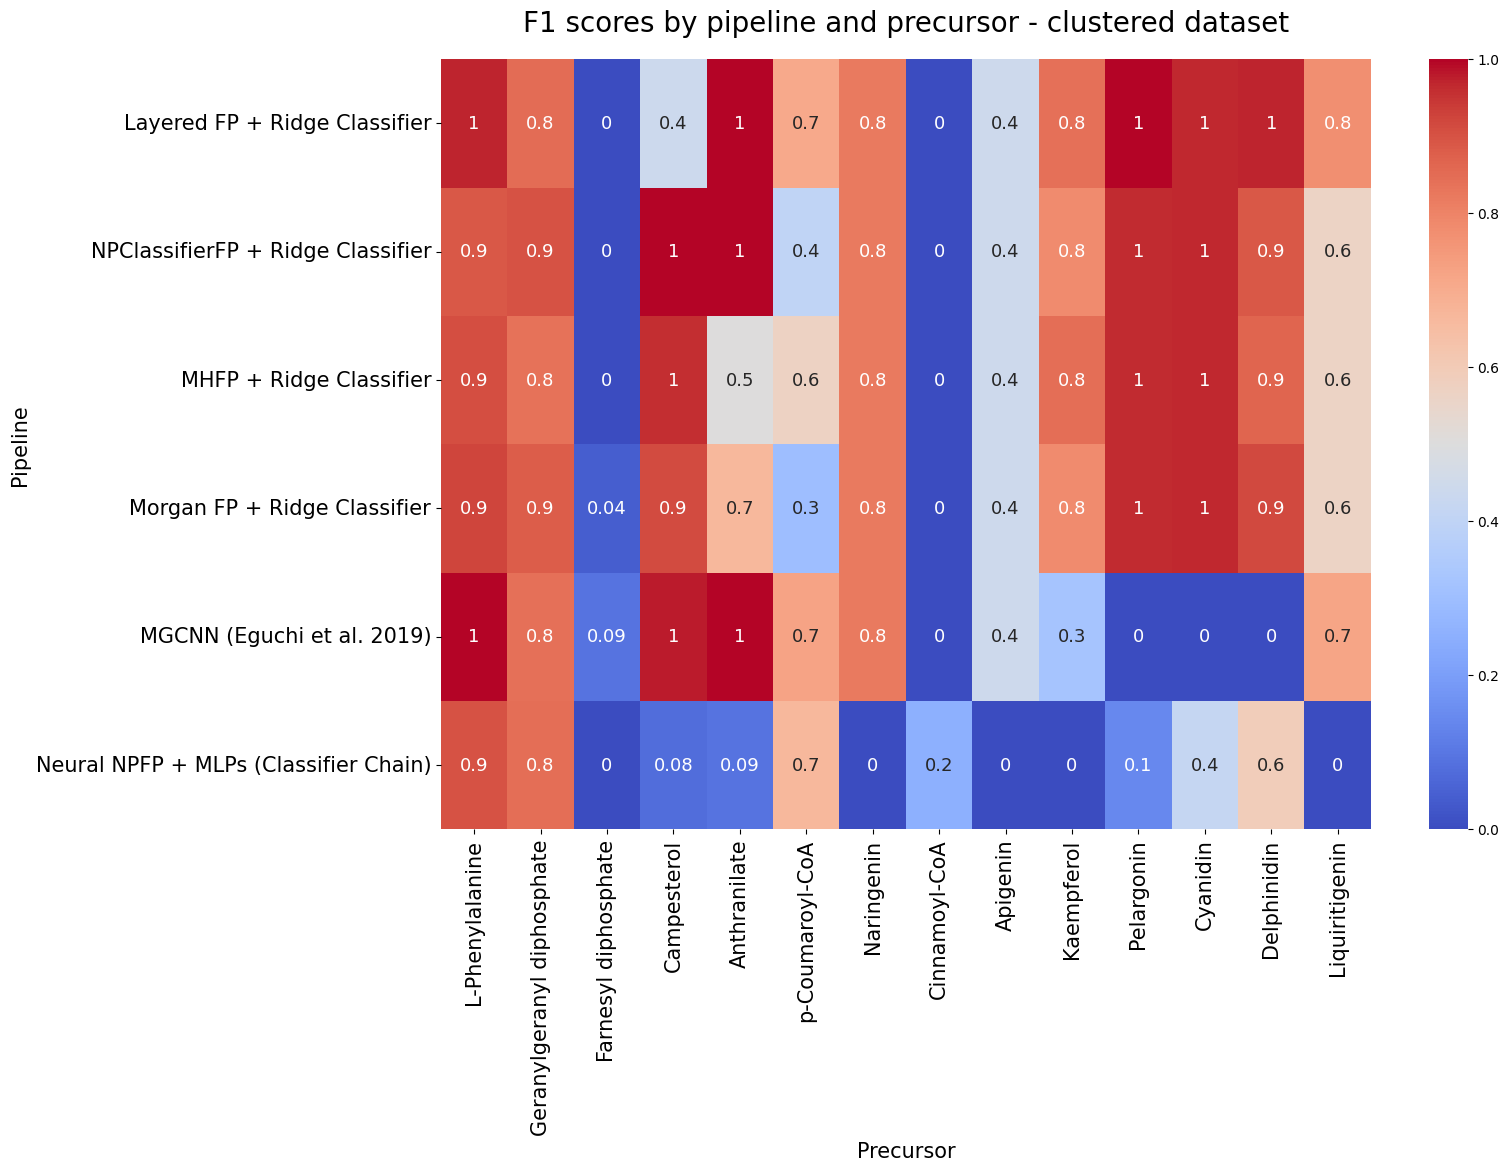

In [90]:
f1_scores = [f1_scores_285, f1_scores_np_classifier, f1_scores_mhfp, f1_scores_morgan_fp, f1_scores_mgcnn, f1_scores_neural_npfp]
pipeline_names = ["Layered FP + Ridge Classifier", "NPClassifierFP + Ridge Classifier", "MHFP + Ridge Classifier", "Morgan FP + Ridge Classifier", "MGCNN (Eguchi et al. 2019)", "Neural NPFP + MLPs (Classifier Chain)"]

df = pd.DataFrame(f1_scores, columns=labels_names, index=pipeline_names)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='.1g', annot_kws={"size": 13})
plt.title('F1 scores by pipeline and precursor - clustered dataset', pad=20, size=20)
plt.xlabel('Precursor', size=15)
plt.ylabel('Pipeline', size=15)
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig("f1_scores_by_pipeline_and_precursor.png", transparent=True)
plt.show()

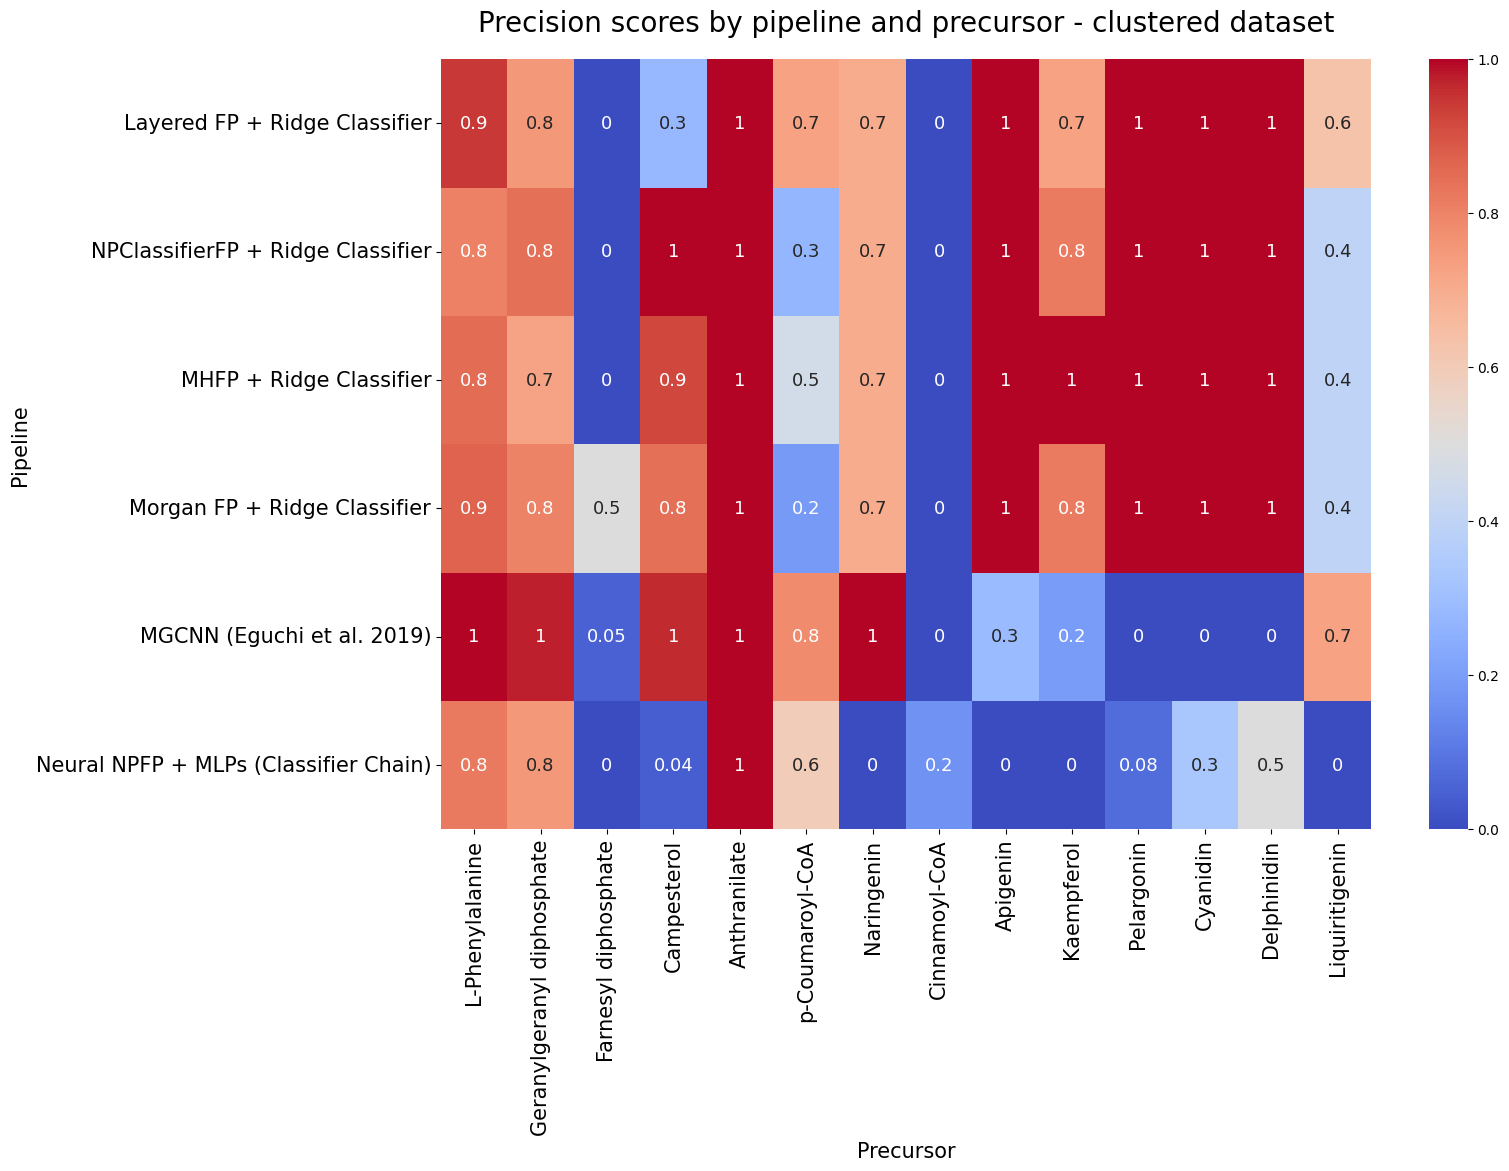

In [91]:
precision_scores = [precision_285, precision_np_classifier, precision_morgan_mhfp, precision_morgan_fp, precision_mgcnn, precision_neural_npfp]
pipeline_names = ["Layered FP + Ridge Classifier", "NPClassifierFP + Ridge Classifier", "MHFP + Ridge Classifier", "Morgan FP + Ridge Classifier", "MGCNN (Eguchi et al. 2019)", "Neural NPFP + MLPs (Classifier Chain)"]

df = pd.DataFrame(precision_scores, columns=labels_names, index=pipeline_names)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='.1g', annot_kws={"size": 13})
plt.title('Precision scores by pipeline and precursor - clustered dataset', pad=20, size=20)
plt.xlabel('Precursor', size=15)
plt.ylabel('Pipeline', size=15)
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig("precision_scores_by_pipeline_and_precursor.png", transparent=True)
plt.show()


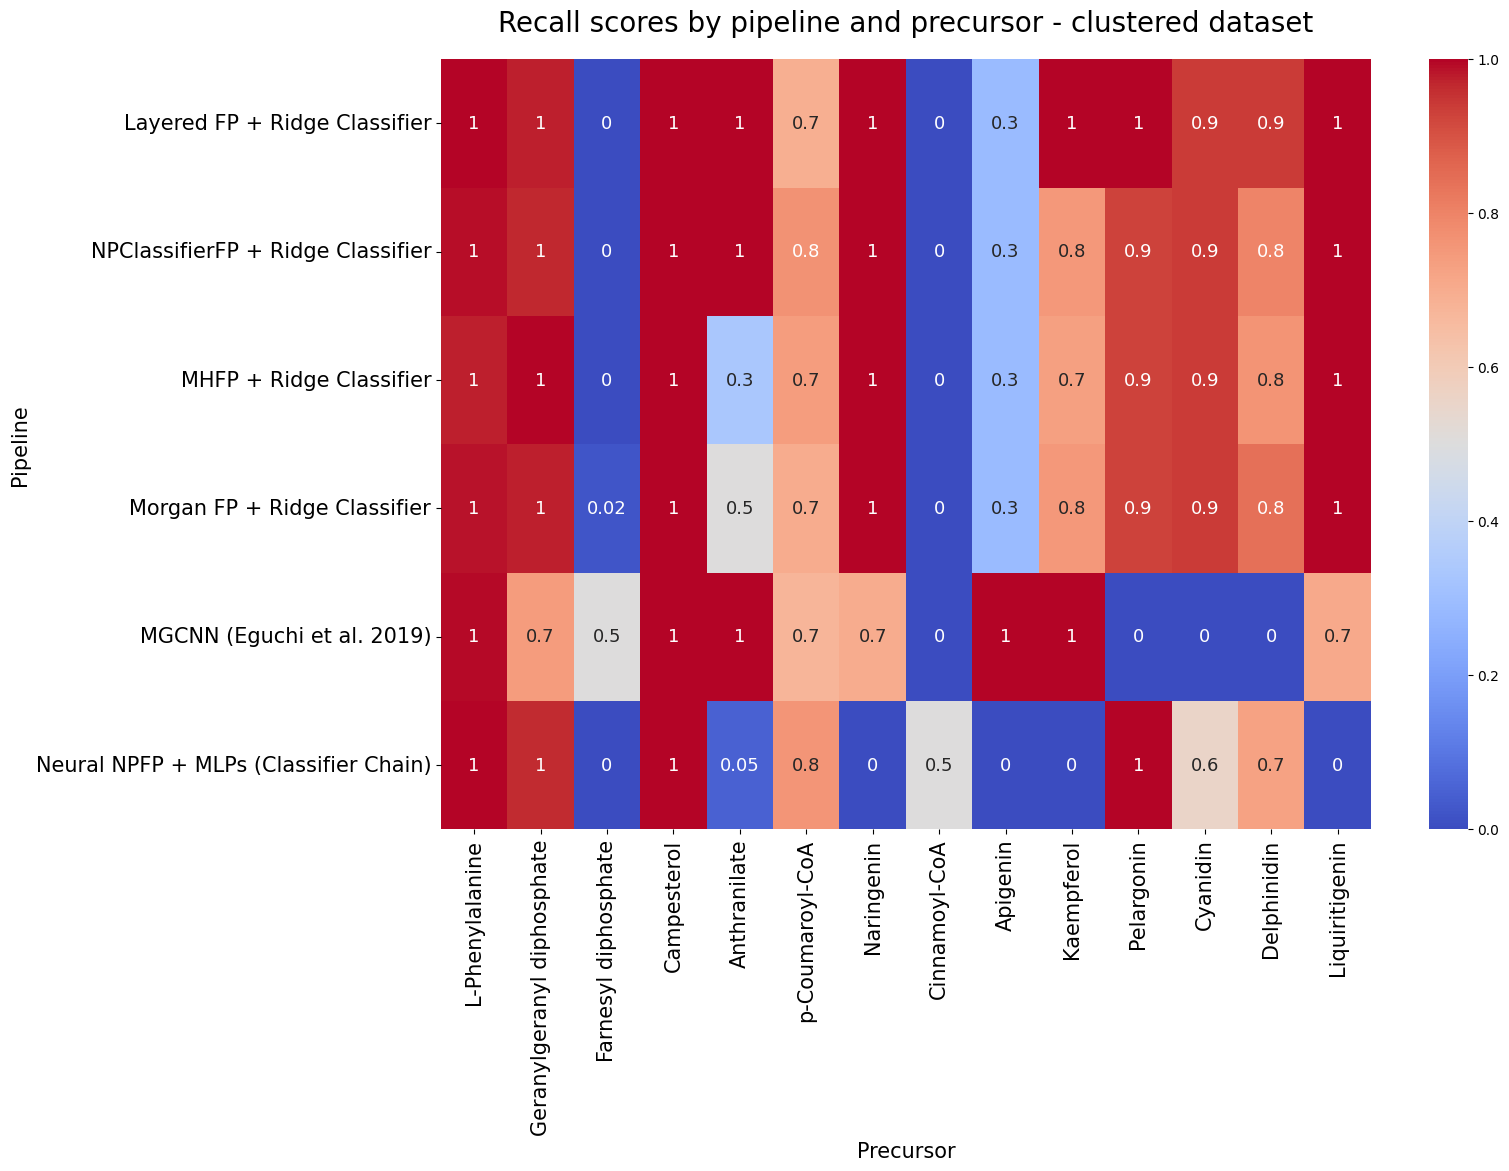

In [93]:
# Replace precision with recall
recall_scores = [recall_285, recall_np_classifier, recall_morgan_mhfp, recall_morgan_fp, recall_mgcnn, recall_neural_npfp]
pipeline_names = ["Layered FP + Ridge Classifier", "NPClassifierFP + Ridge Classifier", "MHFP + Ridge Classifier", "Morgan FP + Ridge Classifier", "MGCNN (Eguchi et al. 2019)", "Neural NPFP + MLPs (Classifier Chain)"]

# Create a DataFrame using recall scores
df = pd.DataFrame(recall_scores, columns=labels_names, index=pipeline_names)

# Plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt='.1g', annot_kws={"size": 13})
plt.title('Recall scores by pipeline and precursor - clustered dataset', pad=20, size=20)
plt.xlabel('Precursor', size=15)
plt.ylabel('Pipeline', size=15)
plt.yticks(size=15)
plt.xticks(size=15)

# Update the filename for recall
plt.savefig("recall_scores_by_pipeline_and_precursor.png", transparent=True)
plt.show()
